In [2]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# for splitting training, validation and test set
from sklearn.model_selection import train_test_split

# mathplot lib
from matplotlib import pyplot as plt
from sklearn.utils import class_weight as cw

# contains randAugmentation, cutMix and MixUp
from keras_cv import layers as kcvl


from tqdm import tqdm 

np.random.seed(777)
tf.random.set_seed(777);

In [3]:
file_path = "/kaggle/input/uniquedataset/uniqueDataset.npz"
data = np.load(file_path)
images = data['images']
labels = data['labels']

# Controlla i primi batch
print("Immagini:", images.shape)
print("Etichette:", labels.shape)

labels = tf.keras.utils.to_categorical(labels, num_classes=8)

print("Images dtype before:", images.dtype)
print("Labels dtype after:", labels.dtype)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/uniquedataset/uniqueDataset.npz'

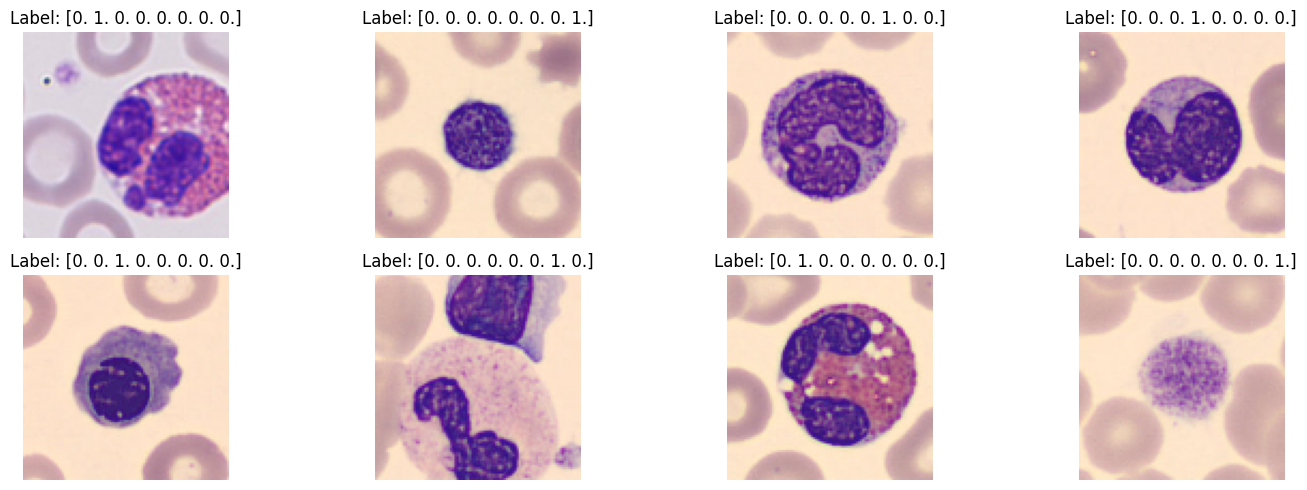

In [3]:
def show_random_samples(images, labels, num_samples=8):
    # Campiona casualmente gli indici
    indices = np.random.choice(len(images), num_samples, replace=False)
    sampled_images = images[indices]
    sampled_labels = labels[indices]

    # Plot delle immagini
    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(zip(sampled_images, sampled_labels)):
        plt.subplot(2, 4, i + 1)  # 2 righe x 5 colonne
        if img.shape[-1] == 1:  # Scala di grigi
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
show_random_samples(images, labels)

In [4]:
decoded_labels = np.argmax(labels, axis=1)  # Decode one-hot labels to class indices

unique_labels, label_counts = np.unique(decoded_labels, return_counts=True)

total_images = len(decoded_labels)  # Total number of images
num_classes = len(unique_labels)  # Number of classes

category_weight = {}

for i in range(num_classes):
    category_weight[unique_labels[i]] = total_images / (num_classes * label_counts[i])

print(category_weight)

{0: 1.7557285546415982, 1: 0.6856929784304727, 2: 1.377073732718894, 3: 0.7385689569945625, 4: 1.759864546525324, 5: 1.5046576032225578, 6: 0.641255364806867, 7: 0.909388314059647}


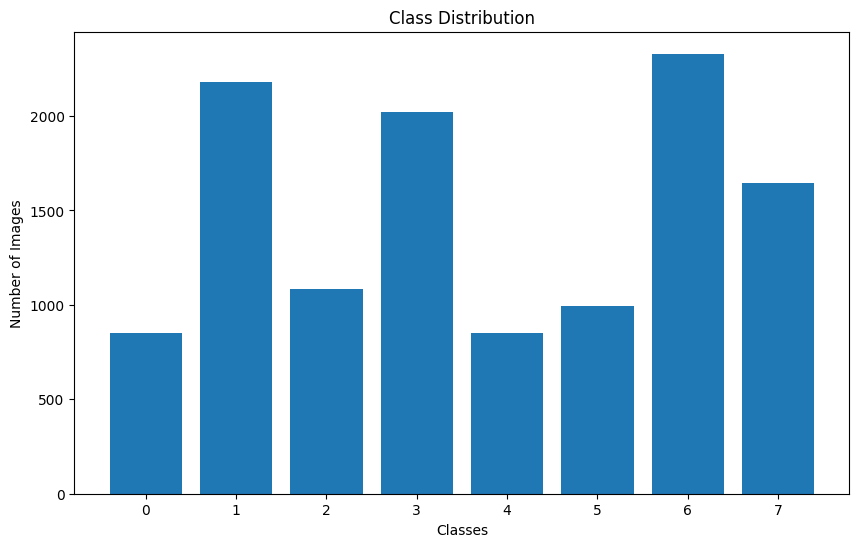

Class 0: 851 images (7.12%)
Class 1: 2179 images (18.23%)
Class 2: 1085 images (9.08%)
Class 3: 2023 images (16.92%)
Class 4: 849 images (7.10%)
Class 5: 993 images (8.31%)
Class 6: 2330 images (19.49%)
Class 7: 1643 images (13.75%)


In [5]:
# Assuming 'decoded_labels' contains the class indices (not one-hot encoded)
# and 'unique_labels' and 'label_counts' are already calculated as in the provided code.

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(unique_labels)  # Ensure all class labels are shown on the x-axis
plt.show()

# Print the class distribution in a more readable format.
for label, count in zip(unique_labels, label_counts):
    print(f"Class {label}: {count} images ({count / total_images * 100:.2f}%)")

In [6]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    images, labels, test_size=0.4, stratify=labels, random_state=42
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val_test shape: {X_val_test.shape}, y_val shape: {y_val_test.shape}")

X_train shape: (7171, 96, 96, 3), y_train shape: (7171, 8)
X_val_test shape: (4782, 96, 96, 3), y_val shape: (4782, 8)


In [7]:
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.1, stratify=y_val_test, random_state=42
)

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_train shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_val shape: {y_test.shape}")

X_val shape: (4303, 96, 96, 3), y_train shape: (4303, 8)
X_test shape: (479, 96, 96, 3), y_val shape: (479, 8)


In [8]:
# Convert to Tensor (this is usefull if we need to transform the images with cutMix and mixUp)
# X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
# y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Hyperparameters
batch_size = 512  # Processa i dati in batch
cutMix = False
mixUp = False
randAugment = True
cutOut = True
splitRotate= True

# Placeholder per immagini e etichette aumentate
X_augmented = []
y_augmented = []

# Funzione per processare in batch
def process_batches(X, y, augmenter, augment_labels=True):
    X_aug = []
    y_aug = []
    
    for i in tqdm (range(0, len(X), batch_size)):
        
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        
        # Applica l'augmentazione
        temp = augmenter({"images": X_batch, "labels": y_batch})
        temp_images = tf.image.resize(temp["images"], [96, 96]).numpy()
        
        if augment_labels:
            temp_labels = temp["labels"].numpy()
        else:
            temp_labels = y_batch.numpy()
        
        X_aug.append(temp_images)
        y_aug.append(temp_labels)
    
    return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)


def cutOut(X_train, mask_size=(32, 32)):

    def cutout(image, mask_size):
        h, w, _ = image.shape
        mask_h, mask_w = mask_size
    
        # Scegli la posizione casuale dove applicare la maschera
        top_left_x = np.random.randint(0, w - mask_w)
        top_left_y = np.random.randint(0, h - mask_h)
    
        # Applicare la maschera (pixel neri)
        image[top_left_y:top_left_y + mask_h, top_left_x:top_left_x + mask_w] = 0
    
        return image
    
    augmented_images = []
    
    for image in X_train:
        # Crea una copia dell'immagine per evitare di modificarla direttamente
        augmented_image = image.copy()
        
        # Applicare CutOut sull'immagine
        augmented_image = cutout(augmented_image, mask_size)
        
        # Aggiungere l'immagine aumentata alla lista
        augmented_images.append(augmented_image)
    
    # Converti la lista di immagini in un array numpy
    augmented_images = np.array(augmented_images)
    
    return augmented_images


def split_rotate(X_train, target_size=(96, 96)):
    def rotate_image(image, angle):
        if angle == 90:
            return np.rot90(image, k=1)
        elif angle == 180:
            return np.rot90(image, k=2)
        elif angle == 270:
            return np.rot90(image, k=3)
        else:
            return image
            
    augmented_images = []
    
    for image in X_train:
        # Dividere l'immagine in 4 quadranti
        height, width, _ = image.shape
        top_left = image[:height//2, :width//2]
        top_right = image[:height//2, width//2:]
        bottom_left = image[height//2:, :width//2]
        bottom_right = image[height//2:, width//2:]
        
        # Ruotare i quadranti separatamente
        angles = np.random.choice([0, 90, 180, 270], size=4)
        rotated_top_left = rotate_image(top_left, angles[0])
        rotated_top_right = rotate_image(top_right, angles[1])
        rotated_bottom_left = rotate_image(bottom_left, angles[2])
        rotated_bottom_right = rotate_image(bottom_right, angles[3])
        
        # Ricomporre l'immagine intera con i quadranti ruotati
        top_half = np.concatenate([rotated_top_left, rotated_top_right], axis=1)
        bottom_half = np.concatenate([rotated_bottom_left, rotated_bottom_right], axis=1)
        final_image = np.concatenate([top_half, bottom_half], axis=0)
        
        # Ridimensionare l'immagine finale per assicurarsi che abbia la forma desiderata
        resized_final_image = np.resize(final_image, target_size + (image.shape[2],)) if len(final_image.shape) == 3 else np.resize(final_image, target_size)
        
        # Aggiungere l'immagine finale alla lista
        augmented_images.append(resized_final_image)
    
    # Converti la lista di immagini in un array numpy
    augmented_images = np.array(augmented_images)
    
    return augmented_images

# Applica CutMix
if cutMix:
    cutmix = kcvl.CutMix(alpha=0.8)
    X_temp, y_temp = process_batches(X_train_tensor, y_train_tensor, cutmix)
    X_augmented.append(X_temp)
    y_augmented.append(y_temp)
    gc.collect

# Applica MixUp
if mixUp:
    mixup = kcvl.MixUp(alpha=0.8)
    X_temp, y_temp = process_batches(X_train_tensor, y_train_tensor, mixup)
    X_augmented.append(X_temp)
    y_augmented.append(y_temp)

if cutOut:
    X_temp = []
    for i in tqdm( range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        temp_images = cutOut(X_batch)
        X_temp.append(temp_images)
    X_augmented.append(np.concatenate(X_temp, axis=0))
    y_augmented.append(y_train)  # CutOut preserva le etichette

if splitRotate:
    X_temp = []
    for i in tqdm( range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        temp_images = split_rotate(X_batch)
        X_temp.append(temp_images)
    X_augmented.append(np.concatenate(X_temp, axis=0))
    y_augmented.append(y_train)  # SplitRotate preserva le etichette

# Applica RandAugment
if randAugment:
    rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=3,
        magnitude=0.2,
        magnitude_stddev=0.2,
        rate=0.5
    )
    X_temp = []
    for i in tqdm( range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        temp_images = rand_augment(X_batch).numpy()
        X_temp.append(temp_images)
    X_augmented.append(np.concatenate(X_temp, axis=0))
    y_augmented.append(y_train)  # RandAugment preserva le etichette

# Applica RandAugment
if randAugment:
    rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=3,
        magnitude=0.2,
        magnitude_stddev=0.2,
        rate=0.5
    )
    X_temp = []
    for i in tqdm( range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        temp_images = rand_augment(X_batch).numpy()
        X_temp.append(temp_images)
    X_augmented.append(np.concatenate(X_temp, axis=0))
    y_augmented.append(y_train)  # RandAugment preserva le etichette
    
    

# Combina i dataset aumentati
X_augmented = np.concatenate(X_augmented, axis=0)
y_augmented = np.concatenate(y_augmented, axis=0)

# Concatenazione finale
X_train = np.concatenate((X_train, X_augmented), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)

100%|██████████| 15/15 [03:12<00:00, 12.84s/it]


In [9]:
print (X_train[8000])

[[[255. 229. 202.]
  [255. 229. 202.]
  [255. 229. 202.]
  ...
  [203. 152. 173.]
  [204. 153. 174.]
  [200. 152. 173.]]

 [[255. 229. 202.]
  [255. 229. 202.]
  [255. 229. 202.]
  ...
  [187. 159. 162.]
  [189. 162. 165.]
  [190. 157. 162.]]

 [[255. 229. 202.]
  [255. 229. 202.]
  [255. 229. 202.]
  ...
  [188. 152. 161.]
  [191. 155. 164.]
  [193. 149. 161.]]

 ...

 [[255. 231. 200.]
  [255. 231. 200.]
  [255. 231. 200.]
  ...
  [255. 231. 201.]
  [255. 231. 201.]
  [255. 231. 201.]]

 [[255. 231. 200.]
  [255. 231. 200.]
  [255. 231. 200.]
  ...
  [255. 231. 201.]
  [255. 231. 201.]
  [255. 231. 201.]]

 [[254. 233. 199.]
  [254. 232. 197.]
  [254. 232. 195.]
  ...
  [255. 229. 202.]
  [255. 229. 202.]
  [255. 229. 202.]]]


Train Images Shape: (35855, 96, 96, 3)
Train Labels Shape: (35855, 8)
[[[255 229 202]
  [255 229 202]
  [255 229 202]
  ...
  [203 152 173]
  [204 153 174]
  [200 152 173]]

 [[255 229 202]
  [255 229 202]
  [255 229 202]
  ...
  [187 159 162]
  [189 162 165]
  [190 157 162]]

 [[255 229 202]
  [255 229 202]
  [255 229 202]
  ...
  [188 152 161]
  [191 155 164]
  [193 149 161]]

 ...

 [[255 231 200]
  [255 231 200]
  [255 231 200]
  ...
  [255 231 201]
  [255 231 201]
  [255 231 201]]

 [[255 231 200]
  [255 231 200]
  [255 231 200]
  ...
  [255 231 201]
  [255 231 201]
  [255 231 201]]

 [[254 233 199]
  [254 232 197]
  [254 232 195]
  ...
  [255 229 202]
  [255 229 202]
  [255 229 202]]]


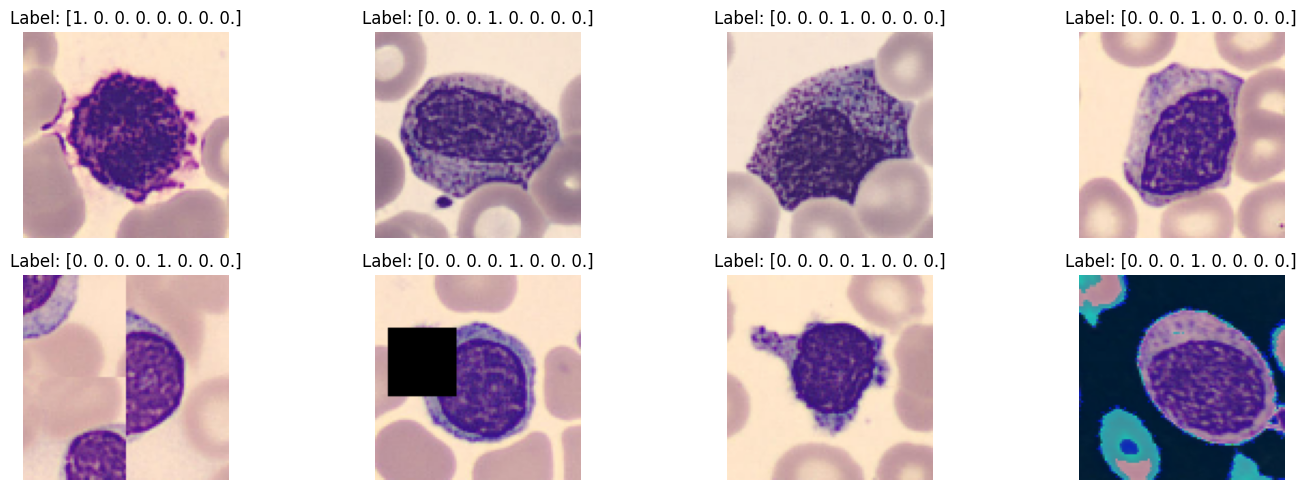

Val Images Shape: (4303, 96, 96, 3)
Val Labels Shape: (4303, 8)
[[[224 193 184]
  [194 154 165]
  [189 147 167]
  ...
  [255 229 202]
  [255 230 203]
  [255 231 204]]

 [[241 218 192]
  [207 169 171]
  [189 145 165]
  ...
  [254 228 201]
  [255 229 202]
  [255 229 202]]

 [[250 230 194]
  [232 197 192]
  [197 153 172]
  ...
  [254 228 201]
  [254 228 201]
  [253 227 200]]

 ...

 [[254 229 198]
  [254 229 199]
  [253 227 200]
  ...
  [253 227 202]
  [253 227 202]
  [253 227 202]]

 [[254 229 197]
  [254 229 199]
  [255 231 201]
  ...
  [253 227 202]
  [253 227 202]
  [253 227 202]]

 [[255 230 201]
  [255 233 202]
  [255 231 196]
  ...
  [249 228 203]
  [249 228 201]
  [250 229 200]]]


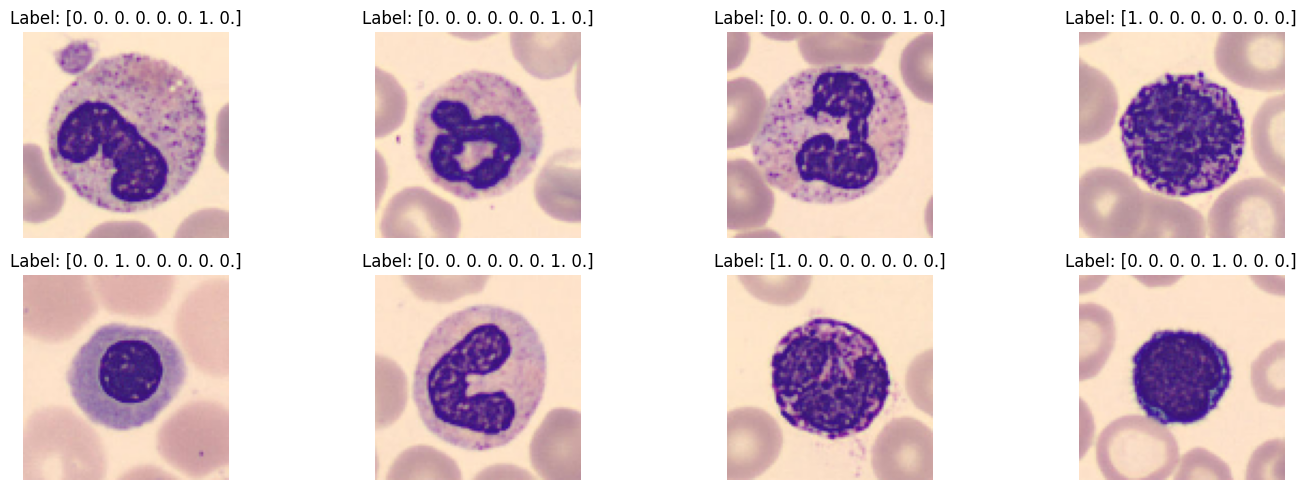

In [14]:
X_train = np.clip(X_train, 0, 255).astype(np.uint8)

print ("Train Images Shape:", X_train.shape)
print ("Train Labels Shape:", y_train.shape)
print (X_train[8000])

show_random_samples(X_train, y_train)

print ("Val Images Shape:", X_val.shape)
print ("Val Labels Shape:", y_val.shape)
print (X_val[4000])

show_random_samples(X_val, y_val)

In [15]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 128
epochs = 121
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 128, Epochs: 121
Input Shape: (96, 96, 3), Output Shape: 8


In [16]:
fen = tfk.applications.ConvNeXtBase(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=(96,96,3),
    pooling='avg',
)
fen.trainable = False

In [23]:
# This method builds the model with given hyperparameters as inputs. The
# rationale behind the model is inside the report.

def build_model(fen, dropout_par, l_par, input_shape=input_shape, output_shape=output_shape):
  # Preprocessing
  inputs = tfkl.Input(shape=input_shape, name='Input')

  # FEN
  x = fen(inputs)
  x = tfkl.Dropout(dropout_par, name='dropout_0')(x)

  # FC
  # First FC block
  x = tfkl.Dense(units=1024, kernel_regularizer=tf.keras.regularizers.l2(l_par), kernel_initializer=tfk.initializers.HeUniform())(x)
  x = tfkl.BatchNormalization(name='batch_norm_1')(x)
  x = tfkl.Activation('relu', name='act_1')(x)
  x = tfkl.Dropout(dropout_par, name='dropout_1')(x)

  # Second FC block
  x = tfkl.Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(l_par), kernel_initializer=tfk.initializers.HeUniform())(x)
  x = tfkl.BatchNormalization(name='batch_norm_2')(x)
  x = tfkl.Activation('relu', name='act_2')(x)
  x = tfkl.Dropout(dropout_par, name='dropout_2')(x)

  outputs = tfkl.Dense(output_shape, name='out', activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Nadam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3,weight_decay=1e-5), metrics=['accuracy'])

  # Display model summary
  model.summary()

  return model

In [24]:
killua = build_model(fen, 0.3, 1e-3, input_shape=(96,96,3), output_shape=8)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 1024)           │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (Activation)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (Activation)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,151,112 (340.08 MB)

 Trainable params: 1,581,576 (6.03 MB)

 Non-trainable params: 87,569,536 (334.05 MB)

In [25]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"category_weight shape: {len(category_weight)}")

X_train shape: (35855, 96, 96, 3)
y_train shape: (35855, 8)
X_val shape: (4303, 96, 96, 3)
y_val shape: (4303, 8)
category_weight shape: 8


In [26]:
from sklearn.utils.class_weight import compute_class_weight
# Calcola la distribuzione delle classi
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),  # Classi del train set
    y=np.argmax(y_train, axis=1)                   # Etichette come array 1D
)

# Convertilo in un dizionario
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.7575980392156862, 1: 0.6858263198163733, 2: 1.376920122887865, 3: 0.7383649093904449, 4: 1.7610510805500983, 5: 1.5039848993288591, 6: 0.6411838340486409, 7: 0.9091024340770791}


In [27]:
sample_weights = []

for label in y_train:
    weight = sum(prob * class_weights[i] for i, prob in enumerate(label))  # Somma pesata per ogni classe
    sample_weights.append(weight)

sample_weights = np.array(sample_weights)

# Verifica la forma del vettore di sample weights
print("Sample Weights Array Shape:", sample_weights.shape)
print("Sample Weights Example:", sample_weights[15637:15658]) #check that the mixUp and cutMix correctly change the weights

Sample Weights Array Shape: (35855,)
Sample Weights Example: [1.37692012 1.76105108 0.90910243 1.76105108 0.64118383 1.5039849
 1.75759804 0.64118383 1.5039849  0.68582632 1.75759804 0.64118383
 1.75759804 1.75759804 0.73836491 1.75759804 0.68582632 1.37692012
 0.73836491 0.90910243 1.37692012]


In [28]:
# Train the model
tl_history = killua.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    sample_weight = sample_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=4, factor=0.2, min_lr=1e-8)]
).history

# Calculate and print the best validation accuracy achieved

final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/121


I0000 00:00:1732286485.685098    1057 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1732286489.222006    1058 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1032 bytes spill stores, 1032 bytes spill loads



280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7565 - loss: 3.3769

I0000 00:00:1732286586.734722    1097 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1732286592.210009    1099 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1032 bytes spill stores, 1032 bytes spill loads



281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7567 - loss: 3.3746

I0000 00:00:1732286620.325763    1137 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1032 bytes spill stores, 1032 bytes spill loads

I0000 00:00:1732286624.961233    1138 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads



281/281 ━━━━━━━━━━━━━━━━━━━━ 174s 470ms/step - accuracy: 0.7570 - loss: 3.3723 - val_accuracy: 0.9503 - val_loss: 1.6428 - learning_rate: 0.0010
Epoch 2/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 85s 304ms/step - accuracy: 0.8805 - loss: 1.6095 - val_accuracy: 0.9454 - val_loss: 0.9227 - learning_rate: 0.0010
Epoch 3/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 85s 301ms/step - accuracy: 0.8895 - loss: 0.9972 - val_accuracy: 0.9417 - val_loss: 0.6562 - learning_rate: 0.0010
Epoch 4/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 301ms/step - accuracy: 0.8904 - loss: 0.7730 - val_accuracy: 0.9377 - val_loss: 0.5607 - learning_rate: 0.0010
Epoch 5/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 300ms/step - accuracy: 0.8906 - loss: 0.6921 - val_accuracy: 0.9442 - val_loss: 0.5002 - learning_rate: 0.0010
Epoch 6/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 85s 301ms/step - accuracy: 0.9069 - loss: 0.5973 - val_accuracy: 0.9570 - val_loss: 0.4096 - learning_rate: 2.0000e-04
Epoch 7/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 84s 300ms/step - accuracy: 0.9

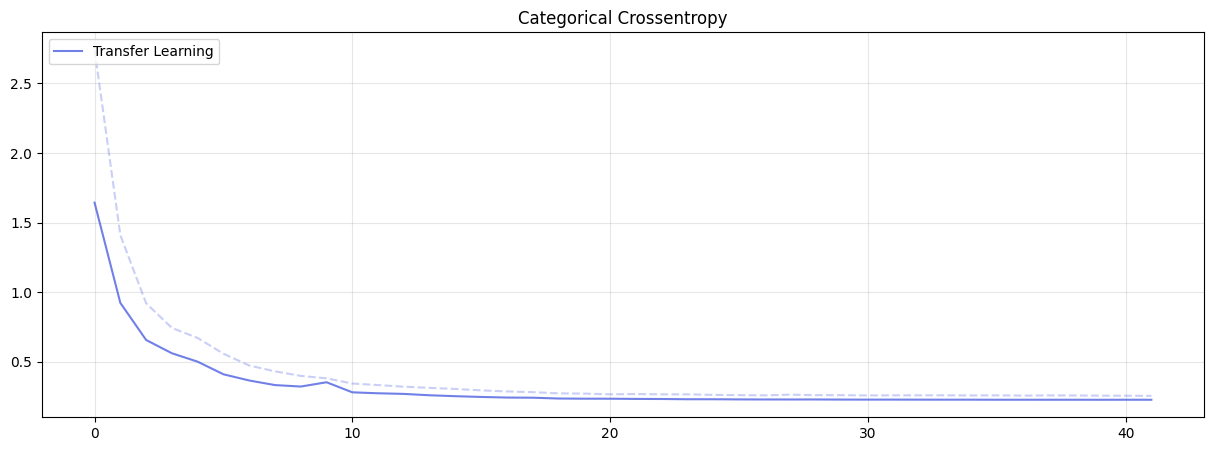

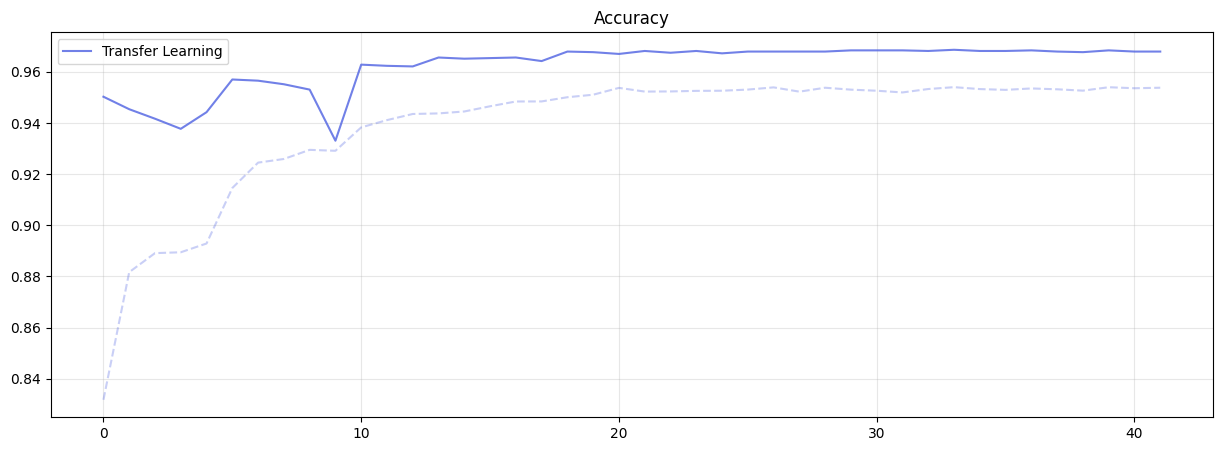

In [29]:
plt.plot(tl_history['accuracy'])
plt.plot(tl_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
# Save the  model
killua.save('/kaggle/working/netero_tf.keras')

I0000 00:00:1732290133.632794    1840 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1032 bytes spill stores, 1032 bytes spill loads

I0000 00:00:1732290140.193468    1839 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads



14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

I0000 00:00:1732290160.685368    1865 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1732290162.363219    1866 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1032 bytes spill stores, 1032 bytes spill loads



15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


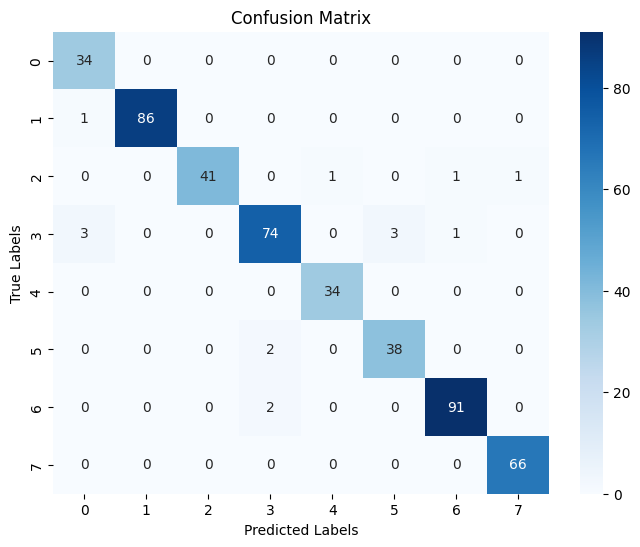

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       1.00      0.99      0.99        87
           2       1.00      0.93      0.96        44
           3       0.95      0.91      0.93        81
           4       0.97      1.00      0.99        34
           5       0.93      0.95      0.94        40
           6       0.98      0.98      0.98        93
           7       0.99      1.00      0.99        66

    accuracy                           0.97       479
   macro avg       0.96      0.97      0.97       479
weighted avg       0.97      0.97      0.97       479



In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = killua.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# **FINE TUNING**

In [32]:
# since keras had some problems with convnex during save/load we added a custom object to save our model in 
killua_ft = tfk.models.load_model('/kaggle/working/netero_tf.keras')
killua_ft.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 1024)           │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (Activation)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (Activation)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,314,266 (352.15 MB)

 Trainable params: 1,581,576 (6.03 MB)

 Non-trainable params: 87,569,536 (334.05 MB)

 Optimizer params: 3,163,154 (12.07 MB)

In [33]:
# Set all layers as trainable
killua_ft.get_layer('convnext_base').trainable = True
for i, layer in enumerate(killua_ft.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

0 input_layer True
1 convnext_base_prestem_normalization True
2 convnext_base_stem True
3 convnext_base_stage_0_block_0_depthwise_conv True
4 convnext_base_stage_0_block_0_layernorm True
5 convnext_base_stage_0_block_0_pointwise_conv_1 True
6 convnext_base_stage_0_block_0_gelu True
7 convnext_base_stage_0_block_0_pointwise_conv_2 True
8 convnext_base_stage_0_block_0_layer_scale True
9 convnext_base_stage_0_block_0_identity True
10 convnext_base_stage_0_block_1_depthwise_conv True
11 convnext_base_stage_0_block_1_layernorm True
12 convnext_base_stage_0_block_1_pointwise_conv_1 True
13 convnext_base_stage_0_block_1_gelu True
14 convnext_base_stage_0_block_1_pointwise_conv_2 True
15 convnext_base_stage_0_block_1_layer_scale True
16 convnext_base_stage_0_block_1_identity True
17 convnext_base_stage_0_block_2_depthwise_conv True
18 convnext_base_stage_0_block_2_layernorm True
19 convnext_base_stage_0_block_2_pointwise_conv_1 True
20 convnext_base_stage_0_block_2_gelu True
21 convnext_base_s

In [34]:
N = 189
for i, layer in enumerate(killua_ft.get_layer('convnext_base').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(killua_ft.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

0 input_layer False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 convnext_base_stage_0_block_1_depthwise_conv False
11 convnext_base_stage_0_block_1_layernorm False
12 convnext_base_stage_0_block_1_pointwise_conv_1 False
13 convnext_base_stage_0_block_1_gelu False
14 convnext_base_stage_0_block_1_pointwise_conv_2 False
15 convnext_base_stage_0_block_1_layer_scale False
16 convnext_base_stage_0_block_1_identity False
17 convnext_base_stage_0_block_2_depthwise_conv False
18 convnext_base_stage_0_block_2_layernorm False
19 convnext_base_stage_0_block_2_pointwise_conv_1 False
20 convnext_base_stage_0_block_2_gelu Fal

In [35]:
# Compile the model
killua_ft.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-3,weight_decay=1e-5), metrics=['accuracy'])

In [37]:
ft_history = killua_ft.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    sample_weight = sample_weights,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=2, factor=0.1, min_lr=1e-8)]
).history


final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/121


I0000 00:00:1732290774.932766    1912 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 1656 bytes spill stores, 1656 bytes spill loads

I0000 00:00:1732290776.074154    1915 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 1776 bytes spill stores, 1768 bytes spill loads

I0000 00:00:1732290787.858554     621 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 24 bytes spill stores, 24 bytes spill loads



280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9176 - loss: 0.4179

I0000 00:00:1732290923.541264    1941 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 1656 bytes spill stores, 1656 bytes spill loads

I0000 00:00:1732290924.300104    1940 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 1776 bytes spill stores, 1768 bytes spill loads



281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9177 - loss: 0.4176

I0000 00:00:1732290933.284096     623 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_41', 24 bytes spill stores, 24 bytes spill loads



281/281 ━━━━━━━━━━━━━━━━━━━━ 218s 576ms/step - accuracy: 0.9178 - loss: 0.4173 - val_accuracy: 0.9347 - val_loss: 0.3561 - learning_rate: 0.0010
Epoch 2/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 130s 461ms/step - accuracy: 0.9687 - loss: 0.1998 - val_accuracy: 0.9558 - val_loss: 0.2359 - learning_rate: 0.0010
Epoch 3/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 128s 456ms/step - accuracy: 0.9812 - loss: 0.1237 - val_accuracy: 0.9668 - val_loss: 0.1863 - learning_rate: 0.0010
Epoch 4/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 129s 458ms/step - accuracy: 0.9850 - loss: 0.0988 - val_accuracy: 0.9693 - val_loss: 0.1770 - learning_rate: 0.0010
Epoch 5/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 129s 458ms/step - accuracy: 0.9884 - loss: 0.1007 - val_accuracy: 0.9712 - val_loss: 0.1542 - learning_rate: 0.0010
Epoch 6/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 128s 456ms/step - accuracy: 0.9923 - loss: 0.0693 - val_accuracy: 0.9772 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 7/121
281/281 ━━━━━━━━━━━━━━━━━━━━ 128s 456ms/step - accuracy: 0

In [ ]:
plt.plot(tl_history['accuracy'])
plt.plot(tl_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**TEST ON NORMAL DATA**

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step


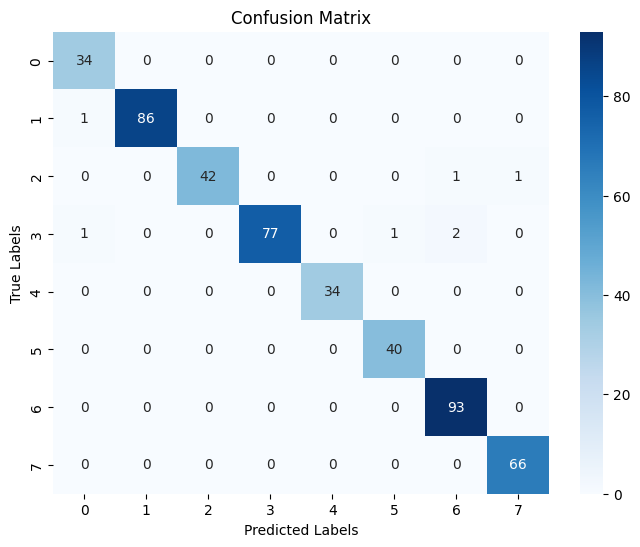

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       1.00      0.99      0.99        87
           2       1.00      0.95      0.98        44
           3       1.00      0.95      0.97        81
           4       1.00      1.00      1.00        34
           5       0.98      1.00      0.99        40
           6       0.97      1.00      0.98        93
           7       0.99      1.00      0.99        66

    accuracy                           0.99       479
   macro avg       0.98      0.99      0.99       479
weighted avg       0.99      0.99      0.99       479



In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = killua_ft.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

**TEST ON AUGMENTED DATA**

100%|██████████| 4/4 [00:13<00:00,  3.50s/it]


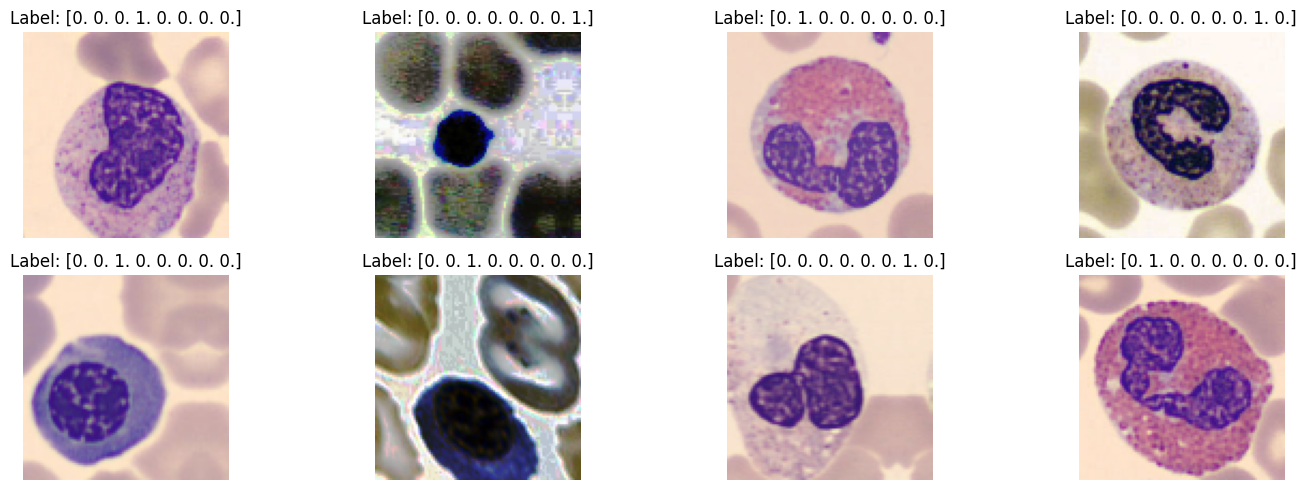

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


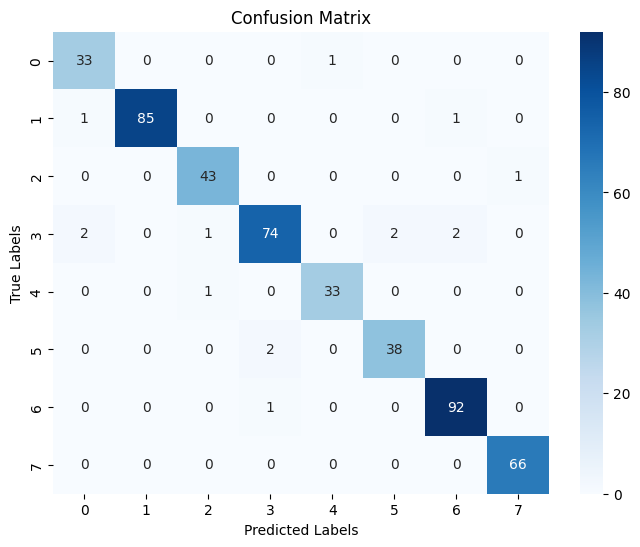

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        34
           1       1.00      0.98      0.99        87
           2       0.96      0.98      0.97        44
           3       0.96      0.91      0.94        81
           4       0.97      0.97      0.97        34
           5       0.95      0.95      0.95        40
           6       0.97      0.99      0.98        93
           7       0.99      1.00      0.99        66

    accuracy                           0.97       479
   macro avg       0.96      0.97      0.97       479
weighted avg       0.97      0.97      0.97       479



In [48]:
rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=3,
        magnitude=0.2,
        magnitude_stddev=0.2,
        rate=0.5
    )
X_test_aug = []
for i in tqdm( range(0, len(X_test), batch_size)):
    X_batch = X_test[i:i + batch_size]
    temp_images = rand_augment(X_batch).numpy()
    X_test_aug.append(temp_images)
X_test_aug = np.concatenate(X_test_aug, axis=0)

X_test_aug = np.clip(X_test_aug, 0, 255).astype(np.uint8)
show_random_samples(X_test_aug, y_test)


# Predict on the test set
y_pred = killua_ft.predict(X_test_aug)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

In [39]:
# Save the  model
killua.save('/kaggle/working/netero_ft.keras')

In [ ]:
class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('/kaggle/working/netero_ft.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)